## Double Tau Rate Plot

In [2]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from coffea import hist
from coffea.processor import defaultdict_accumulator

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)
#hep.CMS.text("Phase 2 Simulation")


import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

# #line thickness
# import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

2023-07-28 10:02:33.337758: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /work/submit/dhoang/DQ/core-inst/lib:/cvmfs/seaquest.opensciencegrid.org/seaquest/software/e1039/share/lib:/cvmfs/seaquest.opensciencegrid.org/seaquest/software/e1039/share/lib64:/e906/app/software/osg/software/e1039/share-20210115/lib:/cvmfs/seaquest.opensciencegrid.org/seaquest/software/e1039/share/lib64:/cvmfs/seaquest.opensciencegrid.org/seaquest/software/e1039/share/root/lib
2023-07-28 10:02:33.337801: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-28 10:02:33.337828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (submit05.mit.edu): /proc/driver/nvidia/version does not exist


----

## For e/m samples

In [5]:
def plot_DTau_rate(ModelName, data_path = "../ntuples/test_bkg_v12_emseed.root", TreeName='ntuplePupDiTau'):
    
    model = load_model(ModelName)
    
    #Load the data
    MinBias = uproot4.open(data_path)
    
    #Pick out unique events
    _, bkg_index = np.unique(np.asarray(MinBias[TreeName]['tree']['event'].array()), return_index=True)
    
    n_event = bkg_index.shape[0]
    
    #Impose the eta and deltaR requirements
    eta1 = np.asarray(MinBias[TreeName]['tree']['eta1'].array())[bkg_index]
    eta2 = np.asarray(MinBias[TreeName]['tree']['eta2'].array())[bkg_index]
    
    phi1 = np.asarray(MinBias[TreeName]['tree']['phi1'].array())[bkg_index]
    phi2 = np.asarray(MinBias[TreeName]['tree']['phi2'].array())[bkg_index]
    
    all_select = (np.abs(eta1) < 2.172) & (np.abs(eta2) < 2.172)
    
    pt1 = np.asarray(MinBias[TreeName]['tree']['pt1'].array())[bkg_index][all_select]
    pt2 = np.asarray(MinBias[TreeName]['tree']['pt2'].array())[bkg_index][all_select]
    
    input1 = np.nan_to_num(np.asarray(MinBias[TreeName]['tree']['m1_inputs'].array())[bkg_index])[all_select]
    input2 = np.nan_to_num(np.asarray(MinBias[TreeName]['tree']['m2_inputs'].array())[bkg_index])[all_select]
    
    pt = np.vstack([pt1, pt2]).transpose()
    pt_min = np.min(pt, axis=1)
    
    #Get the NN score
    score1 = model.predict(input1).flatten()
    score2 = model.predict(input2).flatten()
    
    #Put them together
    NN_score = np.vstack([score1, score2]).transpose()
    NN_score_min = np.min(NN_score, axis=1)
    
    return n_event, pt_min, NN_score_min

In [6]:
n_evt_emseed, pt_min_emseed, NN_min_emseed = plot_DTau_rate('../models/SingleTauID_EMSeed.h5')

18617/18617 [==============================] - 10s 510us/step


In [7]:
#Define the histograms (pT edge and NN Score edge)
pT_edges = list(np.arange(0,100,2)) + [300] #Make sure to capture everything
NN_edges = list([round(i,2) for i in np.arange(0, 1.01, 0.01)])

RateHist = hist.Hist("Counts",
          hist.Bin("pt", "pt", pT_edges),
          hist.Bin("nn", "nn", NN_edges))

RateHist.fill(pt = pt_min_emseed, nn = NN_min_emseed)

In [8]:
rate_list = []
pt_list = []
nn_list = []

#Loop through the edges and integrate
for pt in pT_edges:
    for NN in NN_edges:
#         print("-------")
#         print("pt", pt)
#         print("nn", NN)
        
        rate = RateHist.integrate('pt', slice(pt,300)).integrate('nn', slice(NN,1.)).values()[()]/n_evt_emseed
        rate_list.append(rate*(32e+3))
        
        pt_list.append(pt)
        nn_list.append(NN)

In [9]:
def find_rate(rate_list, target_rate = 11):
    
    RateRange = 0.5 #kHz
    
    idx_list = []
    
    for i in range(len(rate_list)):
        if target_rate-RateRange <= rate_list[i] <= target_rate + RateRange:
            idx_list.append(i)
            
    return idx_list

def plot_rate(rate_list, pt_list, nn_list, target_rate = 11):
    
    fig, ax = plt.subplots()
    im = ax.scatter(nn_list, pt_list, c=rate_list, s=500, marker='s',
                    cmap='Spectral_r',
                    linewidths=0,
                    norm=matplotlib.colors.LogNorm())

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(r'Di-$\tau_h$ rate [kHZ]')

    plt.ylabel(r"Min reco $p_T$ [GeV]")
    plt.xlabel(r"Min NN Score")
    
    plt.xlim([0,0.99])
    plt.ylim([10,100])
    
    #Find the target rate points, plot them and print out some info as well
    target_rate_idx = find_rate(rate_list, target_rate = 11)
    
    legend_count = 0
    for i in target_rate_idx:
        print("Rate: ", rate_list[i])
        print("NN Cut: ", nn_list[i])
        print("pt Cut: ", pt_list[i])
        print("------")
        
        if legend_count == 0:
            plt.scatter(nn_list[i], pt_list[i], s=600, marker='*',
                        color ='firebrick', label = r"$11 \pm 0.5$ kHz")
        else:
            plt.scatter(nn_list[i], pt_list[i], s=600, marker='*',
                        color ='firebrick')
            
        legend_count += 1
    
    plt.legend()
    plt.show()

Rate:  11.055748678205996
NN Cut:  0.86
pt Cut:  16
------
Rate:  11.055748678205996
NN Cut:  0.69
pt Cut:  20
------
Rate:  11.370130157207113
NN Cut:  0.63
pt Cut:  22
------
Rate:  10.531779546537464
NN Cut:  0.64
pt Cut:  22
------
Rate:  11.474923983540819
NN Cut:  0.57
pt Cut:  24
------
Rate:  10.79376411237173
NN Cut:  0.58
pt Cut:  24
------
Rate:  11.1605425045397
NN Cut:  0.52
pt Cut:  26
------
Rate:  10.846161025538583
NN Cut:  0.53
pt Cut:  26
------
Rate:  11.422527070373967
NN Cut:  0.36
pt Cut:  28
------
Rate:  11.055748678205996
NN Cut:  0.37
pt Cut:  28
------
Rate:  10.688970286038025
NN Cut:  0.38
pt Cut:  28
------
Rate:  11.212939417706554
NN Cut:  0.28
pt Cut:  30
------
Rate:  10.846161025538583
NN Cut:  0.29
pt Cut:  30
------
Rate:  10.531779546537464
NN Cut:  0.3
pt Cut:  30
------
Rate:  11.055748678205996
NN Cut:  0.21
pt Cut:  32
------
Rate:  10.584176459704317
NN Cut:  0.22
pt Cut:  32
------
Rate:  11.265336330873408
NN Cut:  0.15
pt Cut:  34
------
R

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


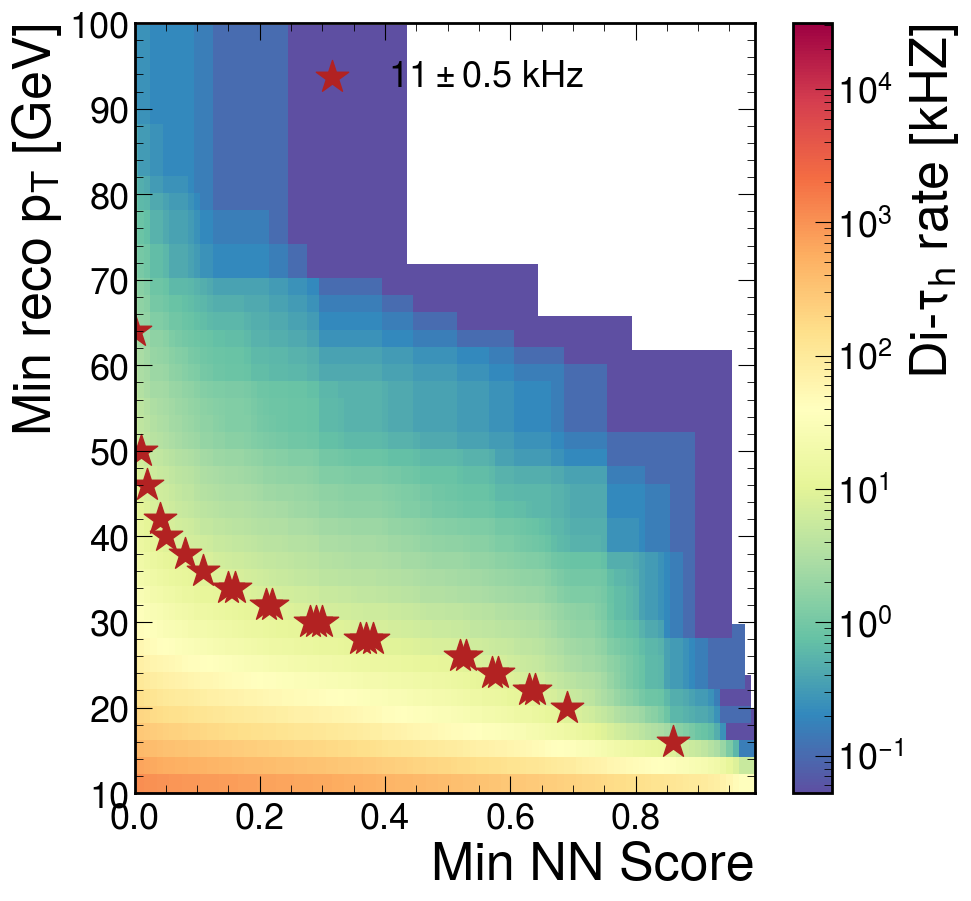

In [10]:
plot_rate(rate_list, pt_list, nn_list)